In [ ]:
import numpy as np
from tqdm import tqdm
from numpy import random
from google.colab import files
import matplotlib.pyplot as plt

# SINR_X_UL
def SINR_X_UL(P_SU):  
  # if (np.sum(P_SU) == 0 ):
  #   print("P_SU:", P_SU)
  return 90 - np.sum(P_SU)

# Costs
def cost(SINR_ij,SINR_th):
  return (SINR_ij - SINR_th)**2


def cost_abs(SINR_ij,SINR_th):
    return abs(SINR_ij - SINR_th)


def cost_4(SINR_ij,SINR_th):
    return (SINR_ij - SINR_th)**4

# p_mat Function
def create_p_mat(current_states,omitted_state,P):
  p_vec = np.zeros(len(current_states))
  for i in range(0,len(current_states)):
    p_vec[i] = P[current_states[i]]
  p_mat = np.zeros((len(P),len(current_states)))
  for i in range(0,len(P)):
    p_mat[i,:] = p_vec
  p_mat[:,omitted_state] = P
  return p_mat

def create_p_vec(current_states,P):
  p_vec = np.zeros((len(current_states),1))
  for i in range(0,len(current_states)):
    p_vec[i] = P[current_states[i]]
  return p_vec
  
def moving_average(a):
  l = len(a[:])
  b = np.zeros(l)
  for i in range(l):
    b[i] = np.mean(a[0:i+1])
  return b

#Parameters
alpha = 0.5
gamma = 0.9
epsilon = 0.1
n_iterations = 25000
P = [-80,-50.3,-30.2,10.1,29.8] # P: set of possible power levels (p), P = {p1...pl}
n_states = len(P)
SINR_th = 23
num_SU = 5

num_trials = 100
QSTACK_cost = np.zeros((num_trials,num_SU,n_iterations+1))
SINRSTACK_cost = np.zeros((num_trials,n_iterations))
COSTSTACK_cost = np.zeros((num_trials,n_iterations))

QSTACK_cost_abs = np.zeros((num_trials,num_SU,n_iterations+1))
SINRSTACK_cost_abs = np.zeros((num_trials,n_iterations))
COSTSTACK_cost_abs = np.zeros((num_trials,n_iterations))

QSTACK_cost_4 = np.zeros((num_trials,num_SU,n_iterations+1))
SINRSTACK_cost_4 = np.zeros((num_trials,n_iterations))
COSTSTACK_cost_4 = np.zeros((num_trials,n_iterations))

In [ ]:
for trial in tqdm(range(0,num_trials)):
  # Q Matrix
  Q = np.zeros((n_states,n_states,num_SU))
  Q_iterations = np.zeros((n_states,n_states,n_iterations+1,num_SU))
  SINR_iterations = np.zeros((n_iterations,1))

  # Reward Matrix
  SINR_vec = np.zeros(n_states)
  for i in range (0,n_states):
    SINR_vec[i] = SINR_X_UL(P[i])

  cost_vec = cost(SINR_vec,SINR_th) # (Difference^2)t
  # cost_vec = cost_abs(SINR_vec,SINR_th) # (|Difference|)
  # cost_vec = cost_4(SINR_vec,SINR_th) # (Difference^4)

  R = np.zeros((n_states,n_states,num_SU));

  # Q-Learning Algorithm
  state = random.randint(len(R[0,:,0]), size=num_SU);
  action = np.zeros(num_SU);
  for i in range(0,n_iterations):
      for k in range(0,num_SU):
          # Create R matrix holding other states constant
          p_mat = create_p_mat(state,k,P);
          for j in range(0,len(P)):
              SINR_vec[j] = SINR_X_UL(p_mat[j,:]);
          cost_vec = cost(SINR_vec,SINR_th);
          for j in range(0,n_states):
                  R[j,:,k] = cost_vec;
          
          # Random Greedy Algorithm choice for next Action
          random_greedy = random.rand(1);
          if random_greedy < epsilon:
              action[k] = random.randint(len(R[0,:,0]));
          else:
              Q[np.isnan(Q)] = 0
              min_Q = np.min(Q[state[k],:,k]);
              possible = np.where(Q[state[k],:,k] == min_Q)
              action[k] =  possible[0][random.randint(len(possible[0]))];

          # Calculating Q and Stochastic Gradiant Descent 
          min_next_Q = np.min(Q[int(action[k]),:,k]);
          discount = gamma*min_next_Q;
          delta_Q = alpha*(R[state[k],int(action[k]),k] + discount - Q[state[k],int(action[k]),k]);
          Q[state[k],int(action[k]),k] = Q[state[k],int(action[k]),k] + delta_Q;
          Q_iterations[:,:,i+1,k] = Q[:,:,k];
          state[k] = action[k];
      SINR_iterations[i] = SINR_X_UL(create_p_vec(state,P))

  cost_iterations = np.zeros((n_iterations,1));
  for i in range(0,n_iterations):
    cost_iterations[i] = cost(SINR_iterations[i],SINR_th);

  # # Normalize final Q table
  # normalized_Q = np.zeros((n_states,n_states,num_SU))
  # for k in range(0,num_SU):
  #   normal_factor = 100/np.max(Q[:,:,k])
  #   normalized_Q[:,:,k]  = np.rint(normal_factor*Q[:,:,k])
  SINRSTACK_cost[trial,:] = SINR_iterations[:].flatten()
  COSTSTACK_cost[trial,:] = cost_iterations[:].flatten()
  for SU in range(0,num_SU):
    QSTACK_cost[trial,SU,:] = Q_iterations[1,1,:,SU]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

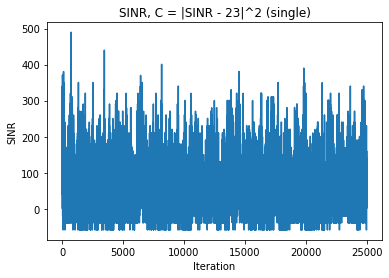

In [ ]:
plt.plot(SINRSTACK_cost[1,:])
plt.xlabel("Iteration")
plt.ylabel("SINR")
plt.title("SINR, C = |SINR - 23|^2 (single)")
plt.savefig('SINR_single_test.pdf')
files.download('SINR_single_test.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

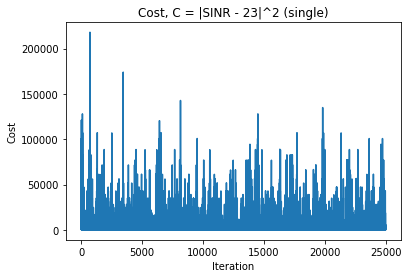

In [ ]:
plt.plot(COSTSTACK_cost[1,:])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost, C = |SINR - 23|^2 (single)")
plt.savefig('COST_single_test.pdf')
files.download('COST_single_test.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

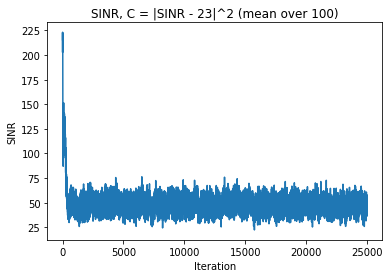

In [ ]:
plt.plot(np.mean(SINRSTACK_cost[:,:],axis=0))
plt.xlabel("Iteration")
plt.ylabel("SINR")
plt.title("SINR, C = |SINR - 23|^2 (mean over 100)")
plt.savefig('SINR_mean_100_test.pdf')
files.download('SINR_mean_100_test.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

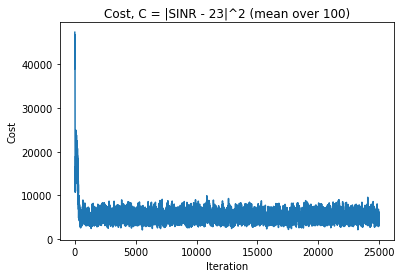

In [ ]:
plt.plot(np.mean(COSTSTACK_cost[:,:],axis=0))
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost, C = |SINR - 23|^2 (mean over 100)")
plt.savefig('COST_mean_100_test.pdf')
files.download('COST_mean_100_test.pdf')
plt.show()

In [ ]:
for trial in tqdm(range(0,num_trials)):
  # Q Matrix
  Q = np.zeros((n_states,n_states,num_SU))
  Q_iterations = np.zeros((n_states,n_states,n_iterations+1,num_SU))
  SINR_iterations = np.zeros((n_iterations,1))

  # Reward Matrix
  SINR_vec = np.zeros(n_states)
  for i in range (0,n_states):
    SINR_vec[i] = SINR_X_UL(P[i])

  # cost_vec = cost(SINR_vec,SINR_th) # (Difference^2)t
  cost_vec = cost_abs(SINR_vec,SINR_th) # (|Difference|)
  # cost_vec = cost_4(SINR_vec,SINR_th) # (Difference^4)

  R = np.zeros((n_states,n_states,num_SU));

  # Q-Learning Algorithm
  state = random.randint(len(R[0,:,0]), size=num_SU);
  action = np.zeros(num_SU);
  for i in range(0,n_iterations):
      for k in range(0,num_SU):
          # Create R matrix holding other states constant
          p_mat = create_p_mat(state,k,P);
          for j in range(0,len(P)):
              SINR_vec[j] = SINR_X_UL(p_mat[j,:]);
          cost_vec = cost_abs(SINR_vec,SINR_th);
          for j in range(0,n_states):
                  R[j,:,k] = cost_vec;
          
          # Random Greedy Algorithm choice for next Action
          random_greedy = random.rand(1);
          if random_greedy < epsilon:
              action[k] = random.randint(len(R[0,:,0]));
          else:
              Q[np.isnan(Q)] = 0
              min_Q = np.min(Q[state[k],:,k]);
              possible = np.where(Q[state[k],:,k] == min_Q)
              action[k] =  possible[0][random.randint(len(possible[0]))];

          # Calculating Q and Stochastic Gradiant Descent 
          min_next_Q = np.min(Q[int(action[k]),:,k]);
          discount = gamma*min_next_Q;
          delta_Q = alpha*(R[state[k],int(action[k]),k] + discount - Q[state[k],int(action[k]),k]);
          Q[state[k],int(action[k]),k] = Q[state[k],int(action[k]),k] + delta_Q;
          Q_iterations[:,:,i+1,k] = Q[:,:,k];
          state[k] = action[k];
      SINR_iterations[i] = SINR_X_UL(create_p_vec(state,P))
      
  cost_iterations = np.zeros((n_iterations,1));
  for i in range(0,n_iterations):
    cost_iterations[i] = cost(SINR_iterations[i],SINR_th);
  # # Normalize final Q table
  # normalized_Q = np.zeros((n_states,n_states,num_SU))
  # for k in range(0,num_SU):
  #   normal_factor = 100/np.max(Q[:,:,k])
  #   normalized_Q[:,:,k]  = np.rint(normal_factor*Q[:,:,k])

  SINRSTACK_cost_abs[trial,:] = SINR_iterations[:].flatten()
  COSTSTACK_cost_abs[trial,:] = cost_iterations[:].flatten()
  for SU in range(0,num_SU):
    QSTACK_cost_abs[trial,SU,:] = Q_iterations[1,1,:,SU]













  0%|          | 0/100 [00:00<?, ?it/s]











  1%|          | 1/100 [00:11<19:21, 11.73s/it]











  2%|▏         | 2/100 [00:23<19:07, 11.71s/it]











  3%|▎         | 3/100 [00:35<18:55, 11.71s/it]











  4%|▍         | 4/100 [00:46<18:43, 11.70s/it]











  5%|▌         | 5/100 [00:58<18:31, 11.70s/it]











  6%|▌         | 6/100 [01:10<18:19, 11.69s/it]











  7%|▋         | 7/100 [01:21<18:11, 11.74s/it]











  8%|▊         | 8/100 [01:33<17:57, 11.71s/it]











  9%|▉         | 9/100 [01:45<17:43, 11.69s/it]











 10%|█         | 10/100 [01:57<17:34, 11.71s/it]











 11%|█         | 11/100 [02:08<17:23, 11.73s/it]











 12%|█▏        | 12/100 [02:20<17:09, 11.70s/it]











 13%|█▎        | 13/100 [02:32<16:56, 11.69s/it]











 14%|█▍        | 14/100 [02:43<16:45, 11.69s/it]











 15%|█▌        | 15/100 [02:55<16:35, 11.72s/it]











 16%|█▌        | 16/100 [03:07<16:23, 11.71s/i

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

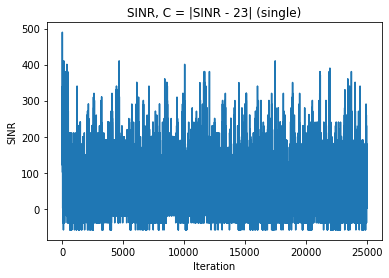

In [ ]:
plt.plot(SINRSTACK_cost_abs[1,:])
plt.xlabel("Iteration")
plt.ylabel("SINR")
plt.title("SINR, C = |SINR - 23| (single)")
plt.savefig('SINR_C2_single_test.pdf')
files.download('SINR_C2_single_test.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

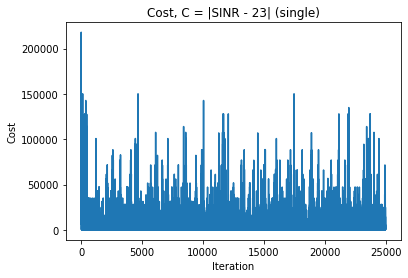

In [ ]:
plt.plot(COSTSTACK_cost_abs[1,:])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost, C = |SINR - 23| (single)")
plt.savefig('COST_C2_single_test.pdf')
files.download('COST_C2_single_test.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

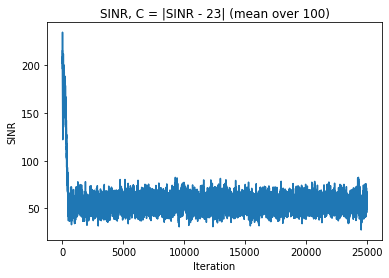

In [ ]:
plt.plot(np.mean(SINRSTACK_cost_abs[:,:],axis=0))
plt.xlabel("Iteration")
plt.ylabel("SINR")
plt.title("SINR, C = |SINR - 23| (mean over 100)")
plt.savefig('SINR_C2_mean_100_test.pdf')
files.download('SINR_C2_mean_100_test.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

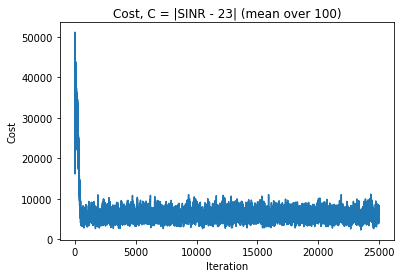

In [ ]:
plt.plot(np.mean(COSTSTACK_cost_abs[:,:],axis=0))
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost, C = |SINR - 23| (mean over 100)")
plt.savefig('COST_C2_mean_100_test.pdf')
files.download('COST_C2_mean_100_test.pdf')
plt.show()

In [ ]:
for trial in tqdm(range(0,num_trials)):
  # Q Matrix
  Q = np.zeros((n_states,n_states,num_SU))
  Q_iterations = np.zeros((n_states,n_states,n_iterations+1,num_SU))
  SINR_iterations = np.zeros((n_iterations,1))

  # Reward Matrix
  SINR_vec = np.zeros(n_states)
  for i in range (0,n_states):
    SINR_vec[i] = SINR_X_UL(P[i])

  # cost_vec = cost(SINR_vec,SINR_th) # (Difference^2)t
  # cost_vec = cost_abs(SINR_vec,SINR_th) # (|Difference|)
  cost_vec = cost_4(SINR_vec,SINR_th) # (Difference^4)

  R = np.zeros((n_states,n_states,num_SU));

  # Q-Learning Algorithm
  state = random.randint(len(R[0,:,0]), size=num_SU);
  action = np.zeros(num_SU);
  for i in range(0,n_iterations):
      for k in range(0,num_SU):
          # Create R matrix holding other states constant
          p_mat = create_p_mat(state,k,P);
          for j in range(0,len(P)):
              SINR_vec[j] = SINR_X_UL(p_mat[j,:]);
          cost_vec = cost_4(SINR_vec,SINR_th);
          for j in range(0,n_states):
                  R[j,:,k] = cost_vec;
          
          # Random Greedy Algorithm choice for next Action
          random_greedy = random.rand(1);
          if random_greedy < epsilon:
              action[k] = random.randint(len(R[0,:,0]));
          else:
              Q[np.isnan(Q)] = 0
              min_Q = np.min(Q[state[k],:,k]);
              possible = np.where(Q[state[k],:,k] == min_Q)
              action[k] =  possible[0][random.randint(len(possible[0]))];

          # Calculating Q and Stochastic Gradiant Descent 
          min_next_Q = np.min(Q[int(action[k]),:,k]);
          discount = gamma*min_next_Q;
          delta_Q = alpha*(R[state[k],int(action[k]),k] + discount - Q[state[k],int(action[k]),k]);
          Q[state[k],int(action[k]),k] = Q[state[k],int(action[k]),k] + delta_Q;
          Q_iterations[:,:,i+1,k] = Q[:,:,k];
          state[k] = action[k];
      SINR_iterations[i] = SINR_X_UL(create_p_vec(state,P))

  cost_iterations = np.zeros((n_iterations,1));
  for i in range(0,n_iterations):
    cost_iterations[i] = cost(SINR_iterations[i],SINR_th);
  # # Normalize final Q table
  # normalized_Q = np.zeros((n_states,n_states,num_SU))
  # for k in range(0,num_SU):
  #   normal_factor = 100/np.max(Q[:,:,k])
  #   normalized_Q[:,:,k]  = np.rint(normal_factor*Q[:,:,k])

  SINRSTACK_cost_4[trial,:] = SINR_iterations[:].flatten()
  COSTSTACK_cost_4[trial,:] = cost_iterations[:].flatten()
  for SU in range(0,num_SU):
    QSTACK_cost_4[trial,SU,:] = Q_iterations[1,1,:,SU]













  0%|          | 0/100 [00:00<?, ?it/s]











  1%|          | 1/100 [00:11<19:43, 11.96s/it]











  2%|▏         | 2/100 [00:24<19:34, 11.99s/it]











  3%|▎         | 3/100 [00:36<19:23, 12.00s/it]











  4%|▍         | 4/100 [00:48<19:15, 12.03s/it]











  5%|▌         | 5/100 [01:00<19:01, 12.01s/it]











  6%|▌         | 6/100 [01:12<18:53, 12.05s/it]











  7%|▋         | 7/100 [01:25<19:07, 12.34s/it]











  8%|▊         | 8/100 [01:37<18:48, 12.27s/it]











  9%|▉         | 9/100 [01:49<18:29, 12.19s/it]











 10%|█         | 10/100 [02:01<18:12, 12.13s/it]











 11%|█         | 11/100 [02:13<17:58, 12.11s/it]











 12%|█▏        | 12/100 [02:25<17:49, 12.15s/it]











 13%|█▎        | 13/100 [02:37<17:32, 12.10s/it]











 14%|█▍        | 14/100 [02:49<17:15, 12.04s/it]











 15%|█▌        | 15/100 [03:01<17:03, 12.05s/it]











 16%|█▌        | 16/100 [03:13<16:52, 12.05s/i

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

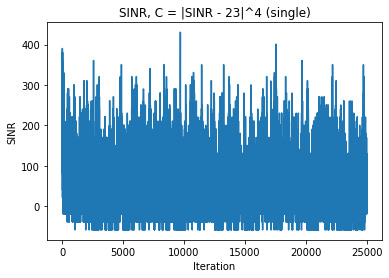

In [ ]:
plt.plot(SINRSTACK_cost_4[1,:])
plt.xlabel("Iteration")
plt.ylabel("SINR")
plt.title("SINR, C = |SINR - 23|^4 (single)")
plt.savefig('SINR_C3_single_test.pdf')
files.download('SINR_C3_single_test.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

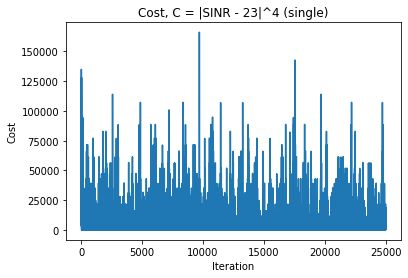

In [ ]:
plt.plot(COSTSTACK_cost_4[1,:])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost, C = |SINR - 23|^4 (single)")
plt.savefig('COST_C3_single_test.pdf')
files.download('COST_C3_single_test.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

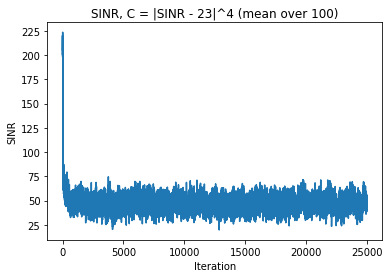

In [ ]:
plt.plot(np.mean(SINRSTACK_cost_4[:,:],axis=0))
plt.xlabel("Iteration")
plt.ylabel("SINR")
plt.title("SINR, C = |SINR - 23|^4 (mean over 100)")
plt.savefig('SINR_C3_mean_100_test.pdf')
files.download('SINR_C3_mean_100_test.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

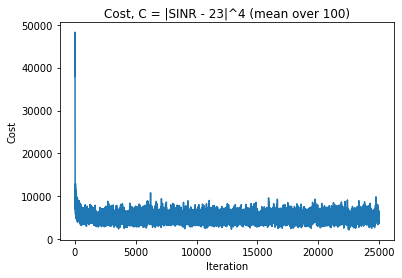

In [ ]:
plt.plot(np.mean(COSTSTACK_cost_4[:,:],axis=0))
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost, C = |SINR - 23|^4 (mean over 100)")
plt.savefig('COST_C3_mean_100_test.pdf')
files.download('COST_C3_mean_100_test.pdf')
plt.show()

other below


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

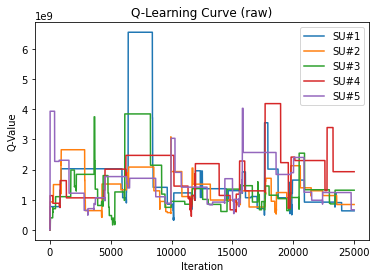

In [ ]:
for SU in range(0,num_SU):
  plt.plot(QSTACK[1,SU,:])
plt.xlabel("Iteration")
plt.ylabel("Q-Value")
plt.title("Q-Learning Curve (raw)")
plt.legend(["SU#1","SU#2","SU#3","SU#4","SU#5"])
plt.savefig('raw_single_test_cost_4.pdf')
files.download('raw_single_test_cost_4.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

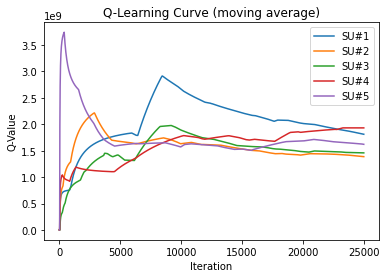

In [ ]:
for SU in range(0,num_SU):
  plt.plot(moving_average(QSTACK[1,SU,:]))
plt.xlabel("Iteration")
plt.ylabel("Q-Value")
plt.title("Q-Learning Curve (moving average)")
plt.legend(["SU#1","SU#2","SU#3","SU#4","SU#5"])
plt.savefig('MA_single_test_cost_4.pdf')
files.download('MA_single_test_cost_4.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

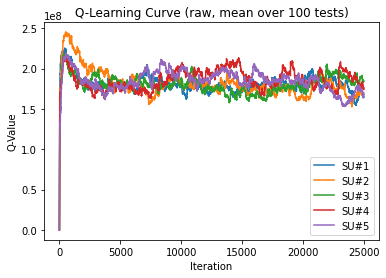

In [ ]:
for SU in range(0,num_SU):
  plt.plot(np.mean(QSTACK[:,SU,:],axis=0))
plt.xlabel("Iteration")
plt.ylabel("Q-Value")
plt.title("Q-Learning Curve (raw, mean over 100 tests)")
plt.legend(["SU#1","SU#2","SU#3","SU#4","SU#5"])
plt.savefig('raw_100_test_cost_4.pdf')
files.download('raw_100_test_cost_4.pdf')
plt.show()

100%|██████████| 5/5 [19:46<00:00, 237.27s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

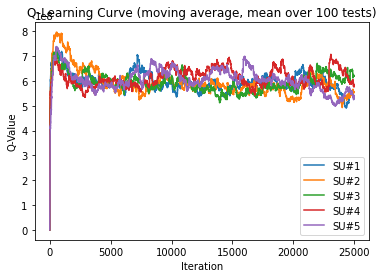

In [ ]:
for SU in tqdm(range(0,num_SU)):
  plt.plot(np.mean(np.apply_along_axis(moving_average,0,QSTACK[:,SU,:]),axis=0))
plt.xlabel("Iteration")
plt.ylabel("Q-Value")
plt.title("Q-Learning Curve (moving average, mean over 100 tests)")
plt.legend(["SU#1","SU#2","SU#3","SU#4","SU#5"])
plt.savefig('MA_100_test_cost_4.pdf')
files.download('MA_100_test_cost_4.pdf')
plt.show()

In [ ]:
# Normalize Data
norm_QSTACK_cost_abs = QSTACK_cost_abs/np.max(QSTACK_cost_abs)
norm_QSTACK_cost = QSTACK_cost/np.max(QSTACK_cost)
norm_QSTACK_cost_4 = QSTACK_cost_4/np.max(QSTACK_cost_4)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

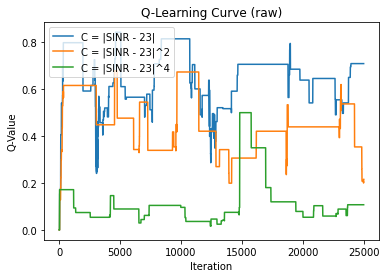

In [ ]:
plt.plot(norm_QSTACK_cost_abs[1,1,:])
plt.plot(norm_QSTACK_cost[1,1,:])
plt.plot(norm_QSTACK_cost_4[1,1,:])

plt.xlabel("Iteration")
plt.ylabel("Q-Value")
plt.title("Q-Learning Curve (raw)")
plt.legend(["C = |SINR - 23|","C = |SINR - 23|^2","C = |SINR - 23|^4"])
plt.savefig('raw_single_test_all_costs.pdf')
files.download('raw_single_test_all_costs.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

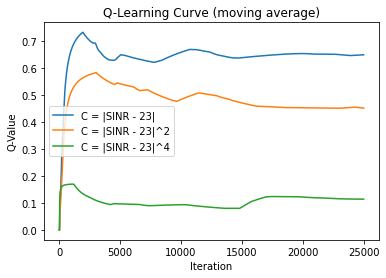

In [ ]:
plt.plot(moving_average(norm_QSTACK_cost_abs[1,1,:]))
plt.plot(moving_average(norm_QSTACK_cost[1,1,:]))
plt.plot(moving_average(norm_QSTACK_cost_4[1,1,:]))

plt.xlabel("Iteration")
plt.ylabel("Q-Value")
plt.title("Q-Learning Curve (moving average)")
plt.legend(["C = |SINR - 23|","C = |SINR - 23|^2","C = |SINR - 23|^4"])
plt.savefig('MA_single_test_all_costs.pdf')
files.download('MA_single_test_all_costs.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

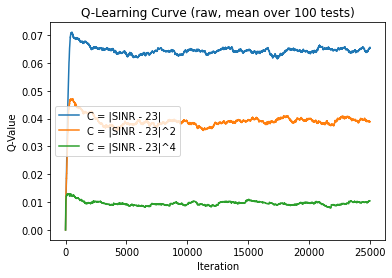

In [ ]:
plt.plot(np.mean(norm_QSTACK_cost_abs[:,1,:],axis=0))
plt.plot(np.mean(norm_QSTACK_cost[:,1,:],axis=0))
plt.plot(np.mean(norm_QSTACK_cost_4[:,1,:],axis=0))

plt.xlabel("Iteration")
plt.ylabel("Q-Value")
plt.title("Q-Learning Curve (raw, mean over 100 tests)")
plt.legend(["C = |SINR - 23|","C = |SINR - 23|^2","C = |SINR - 23|^4"])
plt.savefig('raw_100_test_all_costs.pdf')
files.download('raw_100_test_all_costs.pdf')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

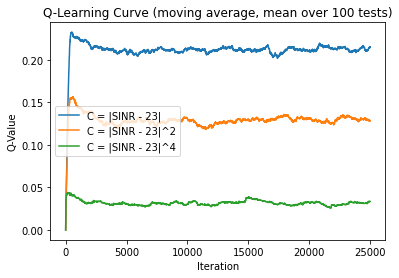

In [ ]:
plt.plot(np.mean(np.apply_along_axis(moving_average,0,norm_QSTACK_cost_abs[:,1,:]),axis=0))
plt.plot(np.mean(np.apply_along_axis(moving_average,0,norm_QSTACK_cost[:,1,:]),axis=0))
plt.plot(np.mean(np.apply_along_axis(moving_average,0,norm_QSTACK_cost_4[:,1,:]),axis=0))

plt.xlabel("Iteration")
plt.ylabel("Q-Value")
plt.title("Q-Learning Curve (moving average, mean over 100 tests)")
plt.legend(["C = |SINR - 23|","C = |SINR - 23|^2","C = |SINR - 23|^4"])
plt.savefig('MA_100_test_all_costs.pdf')
files.download('MA_100_test_all_costs.pdf')
plt.show()